# XGBoost trainer

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api's.

## steps
1. generate an xgboost model configuration by selecting one of 5 available types
2. get a sample of data from a data source (random rows, consecutive rows, or the entire dataset)
3. split the data into train, validation, and test sets.  

> _PLEASE NOTE_:  there are many approaches to cross validation (cv) and as many ways to implement cv in scikit learn.  In this third stage, an alternative, two-way train and test split can be created.  The training set would then, for example, serve as input to a cross validation splitter.  The latter creates multiple training and validation subsets, called folds. These folds are then input, either in sequence or in parallel into the fit algorithm.

4. train the model
5. dump the model
6. generate predictions and probabilities
7. (calibrate probabilities if needed, wip)
8. calculate evaluation statistics and plots

All these steps have been separated here into independent functions since many can be reused for other model types. Some of the following functions will be transferred in the `mlrun.mlutils` module. Additionally, each function contains its own imports in order to isolate and identify dependencies.

In [1]:
# nuclio: ignore
import nuclio

In [2]:
# %nuclio config kind = "job"
# %nuclio config spec.build.baseImage = "mlrun/mlrun"

In [3]:
# %%nuclio cmd -c
# python -m pip install xgboost cloudpickle pandas scikit-learn matplotlib
# python -m pip install seaborn

In [4]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models:0.4.7"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models:0.4.7'


In [5]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
from  mlrun.mlutils import (get_sample,
                            get_splits,
                            gen_sklearn_model,
                            create_class, 
                            eval_class_model)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from cloudpickle import dumps
import pandas as pd

## generate an xgb model

generate a model config using the xgboost's sklearn api

In [7]:
def _gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlrun.mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    from mlrun.mlutils import get_class_fit, gen_sklearn_model

    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

## train

In [8]:
def train_model(
    context: MLClientCtx,
    model_type: str,
    dataset: DataItem,
    label_column: str = "labels",
    sample: int = -1,
    test_size: float = 0.05,
    valid_size: float = 0.75,
    random_state: int = 1,
    model_filename: str = "xgb-model",
    models_dest: str = "",
    plots_dest: str = "",
    score_method: str = "micro",
    file_ext: str = "parquet",
    model_pkg_file: str = "",    
) -> None:
    """train an xgboost model.

    :param context:           the function context
    :param model_type:        the model type to train, 'classifier', 'regressor'...
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param model_filename:    model file filename,  points to a directory
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param file_ext:          format for test_set_key hold out data
    """
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain,ytrain), (xvalid,yvalid), \
    (xtest,ytest), (xcal, ycal) = get_splits(
        raw, labels, 4,
        test_size, 
        valid_size, 
        ["labels"],
        random_state)
    
    # save calibration and test data
    context.log_dataset("test-set", df=pd.concat([xtest, ytest]))
    context.log_dataset("cal-set", df=pd.concat([xcal, ycal]))
    
    # get model config
    model_config = _gen_xgb_model(model_type, context.parameters.items())
    model_short_name = model_config["META"]["class"].split('.')[-1]
   
    # create model instance
    XGBBoostClass = create_class(model_config["META"]["class"])
    model = XGBBoostClass(**model_config["CLASS"])

    # update the model config with training data and callbacks
    model_config["FIT"].update({"X": xtrain,"y": ytrain.values})
    
    # run the fit
    model.fit(**model_config["FIT"])

    # evaluate model
    eval_metrics = eval_class_model(context, xvalid, yvalid, model, plots_dest)
    model_plots = eval_metrics.pop("plots")
    # just do this inside log_model?
#     for plot in model_plots:
#         context.log_artifact(plot, local_path=f'{plots_dest}/{plot.key}.html')
        
    # serialize the model
    model_bin = dumps(model.get_booster())
    context.log_model(model_short_name, body=model_bin, 
                      model_dir="models", 
                      model_file='xgb-trainer-model.pkl',
                      metrics=eval_metrics)
    # cant see them from log_model so try this:
    context.log_results(eval_metrics)

In [9]:
# nuclio: end-code

### mlconfig

In [10]:
from mlrun import mlconf
import os
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [11]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("xgb_trainer")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["training", "ml"]
fn.metadata.labels = {"author": "yjb", "framework": "xgboost"}

fn.export("function.yaml")

[mlrun] 2020-05-04 00:32:29,084 function spec saved to path: function.yaml


### test function

In [12]:
if "V3IO_HOME" in list(os.environ):
    # mlrun on the iguazio platform
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # mlrun is setup using the instructions at 
    # https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc("nfsvol", "nfsvol", "/home/joyan/data"))

In [13]:
gpus = False

task_params = {
    "name" : "tasks xgb cpu trainer",
    "params" : {
        "model_type"         : "classifier",
        "CLASS_num_class"    : 5,
        "CLASS_tree_method"  : "gpu_hist" if gpus else "hist",
        "CLASS_objective"    : "multi:softmax",
        'CLASS_n_estimators' : 100,
        "CLASS_max_depth"    : 6,
        "CLASS_booster"      : "gbtree",  
        "CLASS_random_state" : 1,
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.10,
        "valid_size"         : 0.75,
        "models_dest"        : "xgb_trainer/models",
        "plots_dest"         : "xgb_trainer/plots",
    }}

### run locally

[mlrun] 2020-05-04 00:32:29,203 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-04 00:32:29,203 starting run tasks xgb cpu trainer uid=d9fb622674d64378a7ae3f6c2c3d4895  -> http://mlrun-api:8080
[mlrun] 2020-05-04 00:32:29,240 warning!, server (0.4.6) and client (0.4.7) ver dont match


/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[mlrun] 2020-05-04 00:32:29,637 log artifact test-set at /User/artifacts/test-set.csv, size: 417737, db: Y
[mlrun] 2020-05-04 00:32:29,853 log artifact cal-set at /User/artifacts/cal-set.csv, size: 563867, db: Y
accuracy 1.0
test-error-rate 1750.7368888888889
[mlrun] 2020-05-04 00:32:31,970 log artifact XGBClassifier at /User/artifacts/models/, size: 129439, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...2c3d4895,0,May 04 00:32:29,completed,tasks xgb cpu trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-6fd84575d4-m5dcx,dataset,model_type=classifierCLASS_num_class=5CLASS_tree_method=histCLASS_objective=multi:softmaxCLASS_n_estimators=100CLASS_max_depth=6CLASS_booster=gbtreeCLASS_random_state=1sample=-1label_column=labelstest_size=0.1valid_size=0.75models_dest=xgb_trainer/modelsplots_dest=xgb_trainer/plots,accuracy=1.0test-error-rate=1750.7368888888889precision-micro-avg-classes=1.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,test-setcal-setXGBClassifier


to track results use .show() or .logs() or in CLI: 
!mlrun get run d9fb622674d64378a7ae3f6c2c3d4895 --project default , !mlrun logs d9fb622674d64378a7ae3f6c2c3d4895 --project default
[mlrun] 2020-05-04 00:32:32,105 run executed, status=completed


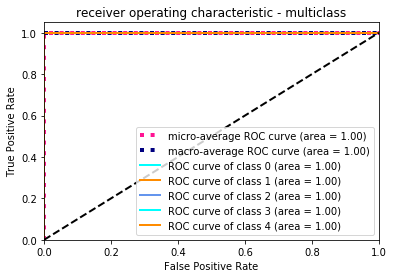

In [14]:
from mlrun import run_local, NewTask

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : os.path.join(mlconf.artifact_path, 'classifier-data.parquet')})

### run remotely

In [15]:
#fn.deploy()
run = fn.run(
    NewTask(**task_params),
    inputs={"dataset"  : os.path.join(mlconf.artifact_path,'classifier-data.parquet')})

[mlrun] 2020-05-04 00:32:32,288 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-04 00:32:32,289 starting run tasks xgb cpu trainer uid=c9092f094da14083b6320486f02d32a3  -> http://mlrun-api:8080
[mlrun] 2020-05-04 00:32:32,420 Job is running in the background, pod: tasks-xgb-cpu-trainer-zsshb
[mlrun] 2020-05-04 00:32:35,882 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-04 00:32:36,404 warning!, server (0.4.6) and client (0.4.7) ver dont match
[mlrun] 2020-05-04 00:32:36,655 log artifact test-set at /User/artifacts/test-set.csv, size: 417737, db: Y
[mlrun] 2020-05-04 00:32:36,840 log artifact cal-set at /User/artifacts/cal-set.csv, size: 563867, db: Y
[mlrun] 2020-05-04 00:32:37,623 Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas/_libs/index.pyx", line 111, in pandas._libs.index.IndexEngine.get_lo

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...f02d32a3,0,May 04 00:32:36,"<div style=""color: red;"" title=""XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,\n importance_type='gain', interaction_constraints=None,\n learning_rate=0.300000012, max_delta_step=0, max_depth=6,\n min_child_weight=1, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,\n objective='multi:softprob', random_state=1, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=None, subsample=1,\n tree_method='hist', validate_parameters=False, verbosity=None)"">error",tasks xgb cpu trainer,host=tasks-xgb-cpu-trainer-zsshbkind=jobowner=adminv3io_user=admin,dataset,CLASS_booster=gbtreeCLASS_max_depth=6CLASS_n_estimators=100CLASS_num_class=5CLASS_objective=multi:softmaxCLASS_random_state=1CLASS_tree_method=histlabel_column=labelsmodel_type=classifiermodels_dest=xgb_trainer/modelsplots_dest=xgb_trainer/plotssample=-1test_size=0.1valid_size=0.75,,test-setcal-set


to track results use .show() or .logs() or in CLI: 
!mlrun get run c9092f094da14083b6320486f02d32a3  , !mlrun logs c9092f094da14083b6320486f02d32a3 
[mlrun] 2020-05-04 00:32:42,086 run executed, status=error
runtime error: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', validate_parameters=False, verbosity=None)


RunError: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', validate_parameters=False, verbosity=None)